In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from si_prefix import si_format
import mc_helper

lsb = 77.51 nA
max error (INL) = 154.09 pA = 0.002 lsb
max difference (DNL) = 130.30 mA = 0.13 lsb

Final dataframe:
     vdd   i(vib)          Iout  code  mc_run          diff    Iout_ideal  \
127  1.8  0.00001  4.607396e-14   0.0       0  4.607396e-14  7.812325e-08   
127  1.8  0.00001  4.660244e-14   0.0       3  4.660244e-14  7.812325e-08   
127  1.8  0.00001  4.822997e-14   0.0       1  4.822997e-14  7.812325e-08   

       Iout_error       inl  dnl  
127 -7.812321e-08 -1.007917  0.0  
127 -7.812321e-08 -1.007917  0.0  
127 -7.812320e-08 -1.007917  0.0  



/tmp/ipykernel_4995/186469868.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf["dnl"][tdf["code"] == 0] = 0


/home/madvlsi/dev/git/7-bit-D-A-converter-MP4-MADVLSI/schematics/simulations/mc_helper.py:13: RuntimeWarning: divide by zero encountered in log10
  precision = max(0, sigfigs - np.floor(np.log10(abs(val))) % 3 - 1)
/home/madvlsi/dev/git/7-bit-D-A-converter-MP4-MADVLSI/schematics/simulations/mc_helper.py:13: RuntimeWarning: invalid value encountered in scalar remainder
  precision = max(0, sigfigs - np.floor(np.log10(abs(val))) % 3 - 1)


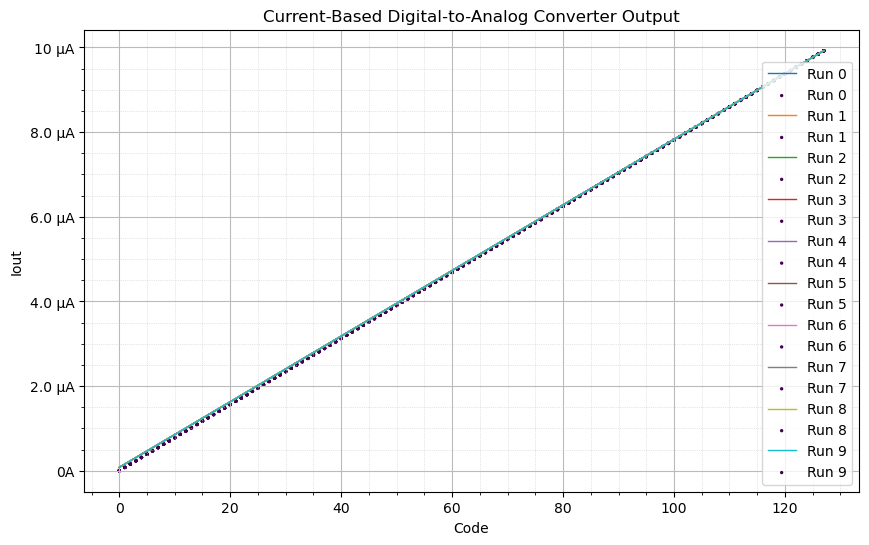

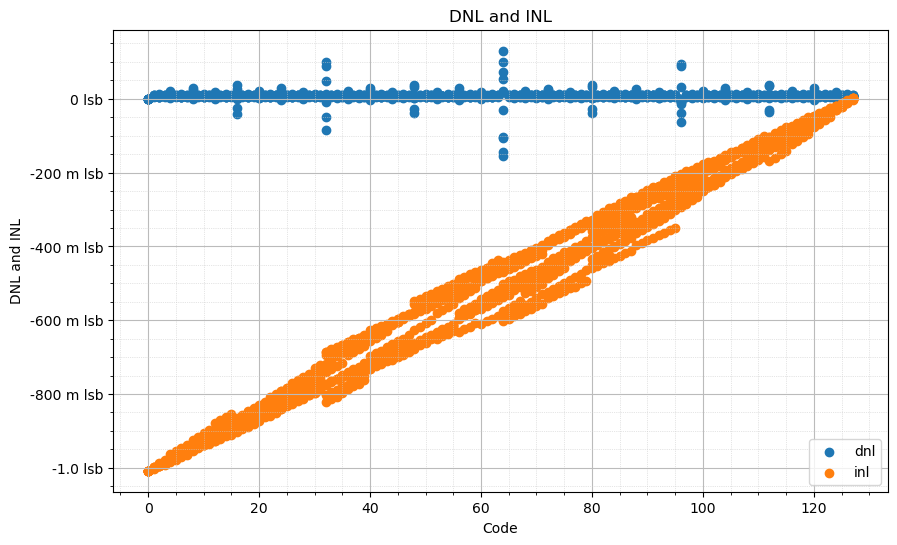

In [8]:
n_bits = 7
n_codes = 2 ** n_bits
mc_simulations = []
# results_dir = "ieee_DAC/simulation_results/"
# results_dir = "ieee_DAC/dac_with_external_bias_gen/test_70"
results_dir = "ieee_DAC/dac_with_external_bias_gen/test_4"

for filenum, filename in enumerate(os.listdir(results_dir)):
    df = pd.read_csv(os.path.join(results_dir, filename), delimiter = "\s+")
    # print("Raw dataframe:")
    # print(df.head(3))
    # print()

    df["code"] = df["v0"] * 0 # init column to all 0s
    for bit in range(n_bits):
        df["code"] = df["code"] + (df[f"v{bit}"] < .5*df["vdd"]) * 2 ** (n_bits - bit - 1)
        df.drop(f"v{bit}", axis = "columns", inplace = True)
    df.rename({"i(viout)": "Iout"}, axis = "columns", inplace = True)
    df["mc_run"] = filenum

    df.sort_values("code", inplace = True)
    df["diff"] = np.diff(df["Iout"], prepend = 0)
    mc_simulations.append(df)

tdf = (pd.concat(mc_simulations)).sort_values("code")
# print("Combined dataframe:")
# print(tdf.head(3))
# print()

plt.figure(figsize = (10, 6))
mc_helper.axes_labels("Code", "", "Iout", "A", "Current-Based Digital-to-Analog Converter Output")
mc_helper.make_grids()

Iout_for_max_code = np.mean(tdf["Iout"][tdf["code"] == max(tdf["code"])])
# Iout_for_min_code = np.mean(tdf["Iout"][tdf["code"] == min(tdf["code"])+1])
Iout_for_min_code = 0
# Iout_for_max_code = 2e-6
# Iout_for_min_code = 850e-9
lsb = (Iout_for_max_code - Iout_for_min_code) / (n_codes - 1)
tdf["Iout_ideal"] = lsb * tdf["code"] + Iout_for_min_code
tdf["Iout_error"] = tdf["Iout"] - tdf["Iout_ideal"]
max_error = max(tdf["Iout_error"])
tdf["inl"] = tdf["Iout_error"] / lsb
max_inl = max(tdf["inl"])
print(f"lsb = {si_format(lsb, precision = 2)}A")
print(f"max error (INL) = {si_format(max_inl * lsb, precision = 2)}A = {np.round(max_inl, 3)} lsb")

tdf["dnl"] = tdf["diff"] / lsb - 1
tdf["dnl"][tdf["code"] == 0] = 0
max_dnl = max(tdf["dnl"])
print(f"max difference (DNL) = {si_format(max_dnl, precision = 2)}A = {np.round(max_dnl, 3)} lsb")
print()

print("Final dataframe:")
print(tdf.head(3))
print()

for i, df_simulation in enumerate(mc_simulations):
    plt.plot(np.array(tdf["code"]), np.array(tdf["Iout_ideal"]), linewidth = 1, label = f"Run {i}")
    plt.scatter(np.array(df_simulation["code"]), np.array(df_simulation["Iout"]), c = df_simulation["mc_run"], s = 2, label = f"Run {i}")
plt.legend(loc = "lower right")

plt.figure(figsize = (10, 6))
mc_helper.axes_labels("Code", "", "DNL and INL", " lsb", "DNL and INL")
mc_helper.make_grids()

plt.scatter(tdf["code"], tdf["dnl"], label = "dnl")
plt.scatter(tdf["code"], tdf["inl"], label = "inl")
plt.legend(loc = "lower right")
# plt.xlim(2, 127)
# plt.ylim(-50, 50)